# Overview

This notebook in intended as a generic notebook to be used with the papermill python library to allow automated generation of analyses and reports for classifiers on microbiome data generated by kraken2 pipeline

In [1]:
cd /project/src

/project/src


In [2]:
from sklearn import model_selection
from sklearn import metrics
import os
import re
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester, list_transformer, DiffExpTransform
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Basic Data Loading

In [3]:
inp_mat_file = '/project/data/raw/justin_paired_end_run_jul_6_2021/PE_50K_freq_mat.csv'
metadata_file = '/project/data/raw/Jie_2017_supp_table_1.xlsx'
identifiers_file = '/project/data/raw/SRA/all_runs.csv'
output_dir = '/project/results/LR_Classifier_DE_w_clinical_complete_generic'
retrain = True

In [4]:
def read_table(fpath, **kwargs):
    """
    read csv or excel file
    
    fpath = filepath
    **kwargs = other arguments to pandas.read_csv or pandas.read_excel
    
    returns: pandas dataframe
    """
    
    if re.search('\\.xls(x)*$', fpath):
        df = pd.read_excel(fpath, **kwargs)
    elif re.search('\\.csv$', fpath):
        df = pd.read_csv(fpath, **kwargs)
    else:
        raise ValueError('Unexpected file type for file {}'.format(fpath))
        
    return df

In [5]:
inp_mat = read_table(inp_mat_file)
matrix_cols = inp_mat.columns[1:len(inp_mat.columns)]
inp_mat['RunID'] = np.array([re.findall('^[A-Z]{3}[0-9]+', x)[0] for x in inp_mat['filename'].to_numpy().astype('str')])
inp_mat = inp_mat.loc[:, np.concatenate((['filename', 'RunID'], matrix_cols.to_numpy()))]
inp_mat.head()

,filename,RunID,Homo sapiens,Blochmannia endosymbiont of Camponotus (Colobopsis) obliquus,Blochmannia endosymbiont of Camponotus nipponensis,Blochmannia endosymbiont of Colobopsis nipponica,Blochmannia endosymbiont of Polyrhachis (Hedomyrma) turneri,Bovine nidovirus 1,Candidatus Aquiluna sp. 15G-AUS-rot,Candidatus Aquiluna sp. UB-MaderosW2red,...,Lonomia obliqua nucleopolyhedrovirus,Microplitis demolitor bracovirus,Neodiprion sertifer nucleopolyhedrovirus,Oxyplax ochracea nucleopolyhedrovirus,Spodoptera exigua multiple nucleopolyhedrovirus,Spodoptera litura granulovirus,Spodoptera litura nucleopolyhedrovirus,Sulfolobales Mexican fusellovirus 1,Human feces pecovirus,Pacmanvirus A23
0,ERR2017411_seqt.subsampled_1_kneaddata_paired_...,ERR2017411,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ERR2017412_seqt.subsampled_1_kneaddata_paired_...,ERR2017412,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ERR2017413_seqt.subsampled_1_kneaddata_paired_...,ERR2017413,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ERR2017414_seqt.subsampled_1_kneaddata_paired_...,ERR2017414,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ERR2017415_seqt.subsampled_1_kneaddata_paired_...,ERR2017415,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
meta_data = read_table(metadata_file, skiprows=2)
meta_data.head()

,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),Body Mass Index (BMI),Waist (cm),Hip (cm),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,N001,0,NaN,52.0,male,165.0,65.0,23.88,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N002,0,NaN,53.0,male,160.0,63.0,24.61,78.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N003,0,NaN,48.0,male,166.0,70.0,25.40,92.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N005,0,NaN,53.0,female,158.0,57.5,23.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N006,0,NaN,53.0,female,150.0,60.0,26.67,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
meta_data['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL525
401    ZSL527
402    ZSL529
403    ZSL530
404    ZSL532
Name: Sample ID, Length: 405, dtype: object

In [8]:
identifiers = read_table(identifiers_file)
identifiers['Sample ID'] = identifiers.pop('Alias')
identifiers.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID
0,0,ERX2076993,ERR2017411,N001
1,0,ERX2076994,ERR2017412,N002
2,0,ERX2076995,ERR2017413,N003
3,0,ERX2076996,ERR2017414,N005
4,0,ERX2076997,ERR2017415,N006


In [9]:
identifiers['Sample ID']

0        N001
1        N002
2        N003
3        N005
4        N006
        ...  
400    ZSL_58
401    ZSL_67
402     ZSL_6
403    ZSL_82
404    ZSL_96
Name: Sample ID, Length: 405, dtype: object

In [10]:
identifiers['Sample ID'] = identifiers['Sample ID'].astype('str')
meta_data['Sample ID'] = meta_data['Sample ID'].astype('str')
meta_data_full = pd.merge(identifiers, meta_data, how='left', on='Sample ID')
meta_data_full.head()

,Unnamed: 0,ExptAcc,RunID,Sample ID,ACVD status,Coronary type,Age (year),Gender,Height (cm),Weight (kg),...,Bisoprolol_9,Fondaparinux Sodium_10,Metoprolol_19,Insulin aspart_6,Isosorbide dinitrate_10,Acarbose_7,Captopril Tablets_6,Estazolam_6,Nitroglycerin Tablets_8,Potassium chloride_32
0,0,ERX2076993,ERR2017411,N001,0,NaN,52.0,male,165.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,ERX2076994,ERR2017412,N002,0,NaN,53.0,male,160.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,ERX2076995,ERR2017413,N003,0,NaN,48.0,male,166.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,ERX2076996,ERR2017414,N005,0,NaN,53.0,female,158.0,57.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,ERX2076997,ERR2017415,N006,0,NaN,53.0,female,150.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
meta_data_full.shape

(405, 58)

# Assemble and Clean Data

In [12]:
meta_data_full = meta_data_full.set_index('RunID')
meta_data_full = meta_data_full.loc[inp_mat['RunID'], :]
inp_mat = inp_mat.set_index('RunID')
# pop filenames from data frame
inp_mat.pop('filename')

RunID
ERR2017411    ERR2017411_seqt.subsampled_1_kneaddata_paired_...
ERR2017412    ERR2017412_seqt.subsampled_1_kneaddata_paired_...
ERR2017413    ERR2017413_seqt.subsampled_1_kneaddata_paired_...
ERR2017414    ERR2017414_seqt.subsampled_1_kneaddata_paired_...
ERR2017415    ERR2017415_seqt.subsampled_1_kneaddata_paired_...
                                    ...                        
ERR2017809    ERR2017809_seqt.subsampled_1_kneaddata_paired_...
ERR2017810    ERR2017810_seqt.subsampled_1_kneaddata_paired_...
ERR2017813    ERR2017813_seqt.subsampled_1_kneaddata_paired_...
ERR2017814    ERR2017814_seqt.subsampled_1_kneaddata_paired_...
ERR2017815    ERR2017815_seqt.subsampled_1_kneaddata_paired_...
Name: filename, Length: 385, dtype: object

In [13]:
feat_meta = pd.DataFrame({'feature': inp_mat.columns.to_numpy().astype('str')})
feat_meta

,feature
0,...
1,Blochmannia endosymbio...
2,Blochmannia endosymbio...
3,Blochmannia endosymbio...
4,Blochmannia endosymbio...
...,...
6496,Spodoptera litura granulovirus
6497,Spodoptera litura nucleopolyhedrovirus
6498,Sulfolobales Mexican fusellovirus 1
6499,Human feces pecovirus


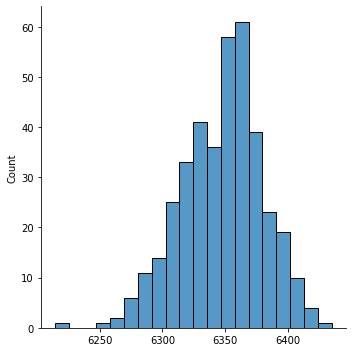

In [14]:
X = inp_mat.to_numpy().astype('float32')
X[np.isnan(X)] = 0.
zero_feats = [np.sum(X[i,:] == 0.) for i in range(X.shape[0])]
sns.displot(zero_feats)

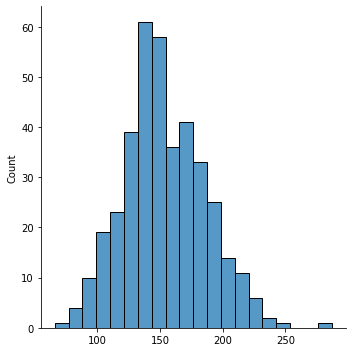

In [15]:
nonzero_feats = [np.sum(X[i,:] != 0.) for i in range(X.shape[0])]
sns.displot(nonzero_feats)

In [16]:
X_centered = X - (X.sum(axis=0)/X.shape[1])
col_vars = np.power(X_centered, 2).sum(axis=0)/X.shape[1]

In [17]:
sum(col_vars == 0)

4559

In [18]:
feats_keep = col_vars != 0
X = X[:, feats_keep]
inp_mat = inp_mat.iloc[:, feats_keep]
feat_meta = feat_meta.iloc[feats_keep, :]
X.shape

(385, 1942)

In [19]:
# check that all values of x are gte 0
assert np.all(X >= 0)

In [20]:
# these samples, if they exist, have 0 detected features
zero_samples = X.sum(axis=1) == 0
# if this is True, then we'd need to remove some samples
any_zero_samples = np.any(zero_samples)
any_zero_samples

False

In [21]:
if any_zero_samples:
    samples_keep = np.logical_not(zero_samples)
    X = X[samples_keep, :]
    meta_data_full = meta_data_full.iloc[samples_keep, :]

In [22]:
print(X.shape)
print(meta_data_full.shape)

(385, 1942)
(385, 57)


In [23]:
meta_data_full.columns

Index(['Unnamed: 0', 'ExptAcc', 'Sample ID', 'ACVD status', 'Coronary type',
       'Age (year)', 'Gender', 'Height (cm)', 'Weight (kg)',
       'Body Mass Index (BMI)', 'Waist (cm)', 'Hip (cm)',
       'Waist Hip Ratio (WHR)', 'Smoking', 'Systolic Blood Pressure (mmHg)',
       'Diastolic Blood Pressure (mmHg)', 'FBG', 'TRIG (mmol/L)',
       'LDLC (mmol/L)', 'CHOL (mmol/L)', 'HDLC (mmol/L)', 'APOB (mg/dl)',
       'APOA (mg/dl)', 'Lpa (mg/dl)', 'HbA1c (%)', 'CKMB (U/L)', 'ALB (U/L)',
       'ALT (U/L)', 'TP (g/L)', 'AST (U/L)', 'CREA (umol/L)', 'CK (U/L)',
       'ProBNP E (Pg/ml)', 'CRP (mg/l)', 'HBDH (U/L）', 'DBIL (umol/L)',
       'BUN (nmol/L)', 'TBIL (umol/L)', 'URIC (umol/L)',
       'Clopidogrel Hydrogen Sulphate Tablets_117', 'Aspirin_33',
       'Atorvastatin_25', 'Esomeprazole_9', 'Isosorbide Mononitrate_11',
       'Potassium Citrate_14', 'Perindopril_15', 'Heparin Sodium_10',
       'Bisoprolol_9', 'Fondaparinux Sodium_10', 'Metoprolol_19',
       'Insulin aspart_6', 'Iso

In [24]:
meta_data_full['ACVD status'].value_counts()


1    214
0    171
Name: ACVD status, dtype: int64

In [25]:
np.any(np.isnan(meta_data_full['ACVD status'].to_numpy()))

False

In [26]:
meta_data_full['Gender'].value_counts()

male      226
female    154
Name: Gender, dtype: int64

In [27]:
# not enough data for smoking status, so we omit it
meta_data_full['Smoking'].value_counts()

no         23
smoking    11
Name: Smoking, dtype: int64

In [28]:
meta_data_input = meta_data_full.loc[:, ['Age (year)', 'Body Mass Index (BMI)', 'Gender']]
gender_vect = np.reshape(meta_data_input['Gender'].to_numpy().astype('str'), (meta_data_input.shape[0], 1))
gender_encoder = OneHotEncoder(sparse=False)
gender_encoded = gender_encoder.fit_transform(gender_vect)
print(gender_encoded.shape)

(385, 3)


In [29]:
print(gender_encoder.categories_)

[array(['female', 'male', 'nan'], dtype='<U6')]


In [30]:
gender_encoded[gender_vect.flatten() == 'nan', np.logical_not(gender_encoder.categories_ == 'nan')] = np.nan
gender_encoded = np.delete(gender_encoded, 2, 1)
# 1 for gender encoded = male. 0 = female. nan means no data
gender_encoded = np.delete(gender_encoded, 0, 1)

In [31]:
meta_data_mat = meta_data_input.loc[:, ['Age (year)', 'Body Mass Index (BMI)']].to_numpy().astype('float32')
meta_data_mat = np.concatenate([meta_data_mat, gender_encoded], axis = 1)
meta_data_mat.shape

(385, 3)

In [32]:
np.sum(np.isnan(meta_data_mat))

84

In [33]:
# 7 missing values for age, 72 missing values for BMI. 5 values missing for sex
for i in range(meta_data_mat.shape[1]):
    print(np.sum(np.isnan(meta_data_mat[:, i])))

7
72
5


In [34]:
# we remove all samples for which no clinical data exists
samples_keep = [np.all(np.logical_not(np.isnan(meta_data_mat[i, :]))) for i in range(meta_data_mat.shape[0])]
meta_data_mat = meta_data_mat[samples_keep, :]
X = X[samples_keep, :]

In [35]:
meta_data_mat.shape

(305, 3)

In [36]:
y = meta_data_full['ACVD status'].to_numpy().astype('int32')[samples_keep]

In [37]:
y.shape

(305,)

# Quick PCA of Differentially Expressed Features in Data

In [38]:
DE = DiffExpTransform()
DE.fit(X, y)

In [39]:
# ACVD negative associated features
DE.results['0'][DE.results['0']['rejected'] == True]

,tstat,pval,p_adj,rejected
16,5.042362,3.964899e-07,NaN,True
30,3.562363,2.133557e-04,NaN,True
31,3.935954,5.141830e-05,NaN,True
32,3.269755,6.002014e-04,NaN,True
99,3.920542,5.464975e-05,NaN,True
123,3.765238,9.991983e-05,NaN,True
141,5.325682,9.818777e-08,NaN,True
225,3.427371,3.468698e-04,NaN,True
230,3.399218,3.831415e-04,NaN,True
232,3.717678,1.197291e-04,NaN,True


In [40]:
DE.results['0'][DE.results['0']['rejected'] == True].shape[0]

28

In [41]:
# ACVD positive associated features
DE.results['1'][DE.results['1']['rejected'] == True]

,tstat,pval,p_adj,rejected
152,2.965299,0.001632,NaN,True
237,3.876082,0.000065,NaN,True
247,4.015313,0.000037,NaN,True
311,3.105783,0.001039,NaN,True
333,4.643843,0.000003,NaN,True
...,...,...,...,...
1576,4.594364,0.000003,NaN,True
1577,3.421023,0.000355,NaN,True
1578,4.231629,0.000015,NaN,True
1580,4.386959,0.000008,NaN,True


In [42]:
DE.results['1'][DE.results['1']['rejected'] == True].shape[0]

74

In [43]:
std_scaler_full = StandardScaler()
X_scaled_full = std_scaler_full.fit_transform(DE.transform(X))
PCA_full = PCA()
X_PCA_full = PCA_full.fit_transform(X_scaled_full)

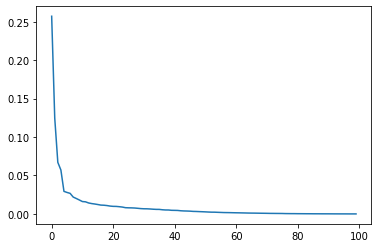

In [44]:
plt.plot(PCA_full.explained_variance_ratio_[0:100])

In [45]:
PCA_plot_df = pd.DataFrame(X_PCA_full, columns = np.array(['PC{}'.format(i) for i in range(1, X_PCA_full.shape[1] + 1)]))

In [46]:
PCA_plot_df['ACVD status'] = y
# PCA_plot_df['gender'] = gender_vect
# PCA_plot_df['BMI'] = meta_data_full['Body Mass Index (BMI)']
# PCA_plot_df['Age'] = meta_data_full['Age (year)']

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

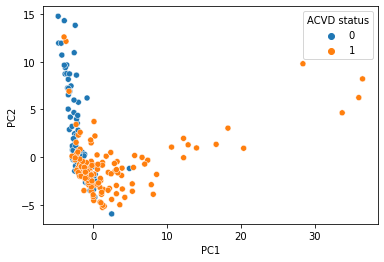

In [47]:
sns.scatterplot(data=PCA_plot_df, x='PC1', y='PC2', hue='ACVD status')

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

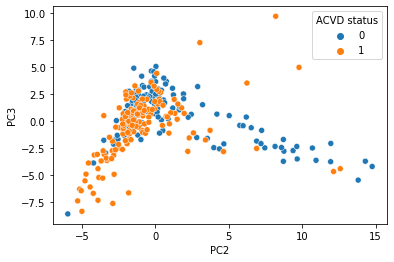

In [48]:
sns.scatterplot(data=PCA_plot_df, x='PC2', y='PC3', hue='ACVD status')

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

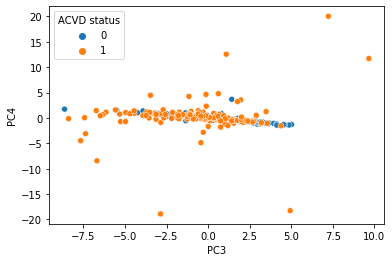

In [49]:
sns.scatterplot(data=PCA_plot_df, x='PC3', y='PC4', hue='ACVD status')

<AxesSubplot:xlabel='ACVD status', ylabel='PC3'>

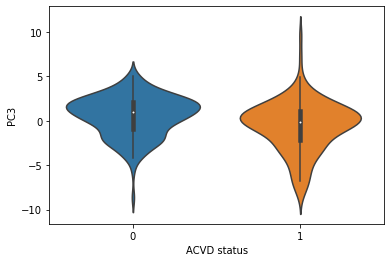

In [50]:
sns.violinplot(data=PCA_plot_df, x='ACVD status', y='PC3')

<AxesSubplot:xlabel='ACVD status', ylabel='PC4'>

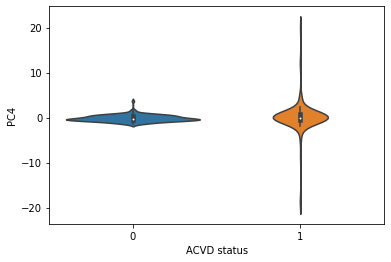

In [51]:
sns.violinplot(data=PCA_plot_df, x='ACVD status', y='PC4')

# Train Model

In [52]:
meta_data_mat.shape

(305, 3)

In [53]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

n_splits = 10
out_path = os.path.join(output_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(output_dir):
        os.system('rm -rf ' + output_dir)
    os.mkdir(output_dir)
    # random seed here deals with model initialization
    # random seed here deals with model initialization
    MyLogistic = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                         solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                        scoring=metrics.make_scorer(RECALL_SCORE))

    # setup pipeline and Trainer
    MyPipeLine = Pipeline([('DE0', DiffExpTransform()), ('scaler0', StandardScaler()), ('pca', PCA(n_components=10))])
    ListTransform = list_transformer([MyPipeLine, MinMaxScaler()])
    MyTrainer = Trainer(model=MyLogistic, pipeline_X=ListTransform)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)
    MyMultiTrainTester.train([X, meta_data_mat], y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()

Running for split 1 of 10
Using predict_proba
getting predictions from probs
Running for split 2 of 10
Using predict_proba
getting predictions from probs
Running for split 3 of 10
Using predict_proba
getting predictions from probs
Running for split 4 of 10
Using predict_proba
getting predictions from probs
Running for split 5 of 10
Using predict_proba
getting predictions from probs
Running for split 6 of 10
Using predict_proba
getting predictions from probs
Running for split 7 of 10
Using predict_proba
getting predictions from probs
Running for split 8 of 10
Using predict_proba
getting predictions from probs
Running for split 9 of 10
Using predict_proba
getting predictions from probs
Running for split 10 of 10
Using predict_proba
getting predictions from probs


In [54]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.781989,train
1,0.765995,train
2,0.730242,train
3,0.777105,train
4,0.785618,train
5,0.785618,train
6,0.764823,train
7,0.753387,train
8,0.768900,train
9,0.810353,train


<AxesSubplot:xlabel='stage', ylabel='score'>

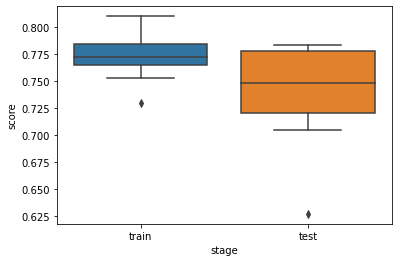

In [55]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [56]:
hyperparams = {'l1_ratio': [], 'C': []}
for i in range(n_splits):
    hyperparams['l1_ratio'].append(MyMultiTrainTester.TrainerList[i].model.l1_ratio_)
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.C_)
hyperparams_df = pd.DataFrame(hyperparams)
hyperparams_df

,l1_ratio,C
0,[0.0],[22026.465794806718]
1,[0.0],[1096.6331584284585]
2,[0.30000000000000004],[0.0024787521766663585]
3,[0.6000000000000001],[0.1353352832366127]
4,[0.0],[0.36787944117144233]
5,[0.0],[0.36787944117144233]
6,[0.5],[0.36787944117144233]
7,[1.0],[0.1353352832366127]
8,[0.4],[0.1353352832366127]
9,[0.0],[22026.465794806718]


<AxesSubplot:xlabel='score_type', ylabel='value'>

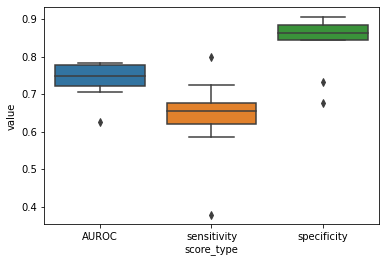

In [57]:
def AUROC_SCORE(y_true, y_pred):
    return metrics.roc_auc_score(y_true, y_pred, average='macro')
def SENSITIVITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=1)
def SPECIFICITY_SCORE(y_true, y_pred):
    return metrics.recall_score(y_true, y_pred, average='binary', pos_label=0)

scorer_list = [AUROC_SCORE, SENSITIVITY_SCORE, SPECIFICITY_SCORE]
scorer_names = ['AUROC', 'sensitivity', 'specificity']
other_metrics = {'split': [], 'score_type': [], 'value': []}
for i in range(n_splits):
    test_idx = MyMultiTrainTester.test_idx[i]
    X_test = [X[test_idx, :], meta_data_mat[test_idx, :]]
    y_test = y[test_idx]
    Trainer_i = MyMultiTrainTester.TrainerList[i]
    for j in range(len(scorer_list)):
        score_type = scorer_names[j]
        score_func = scorer_list[j]
        other_metrics['split'].append(i)
        other_metrics['score_type'].append(score_type)
        other_metrics['value'].append(Trainer_i.score(X_test, y_test, score_func))
    
other_metrics_df = pd.DataFrame(other_metrics)
sns.boxplot(data = other_metrics_df, x = 'score_type', y = 'value')

In [58]:
# median AUROC (macro average of + and -)
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'AUROC'])

0.7484012283074148

In [59]:
# std dev
np.std(other_metrics_df['value'][other_metrics_df['score_type'] == 'AUROC'])

0.04584936215765334

In [60]:
# median sensitivity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.6551724137931034

In [61]:
# std dev
np.std(other_metrics_df['value'][other_metrics_df['score_type'] == 'sensitivity'])

0.10369032167382684

In [62]:
# median specificity
np.median(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.864367816091954

In [63]:
# std dev
np.std(other_metrics_df['value'][other_metrics_df['score_type'] == 'specificity'])

0.07171375545285108

In [64]:
other_metrics_df.to_csv(os.path.join(output_dir, 'misc_score_metrics.csv'))

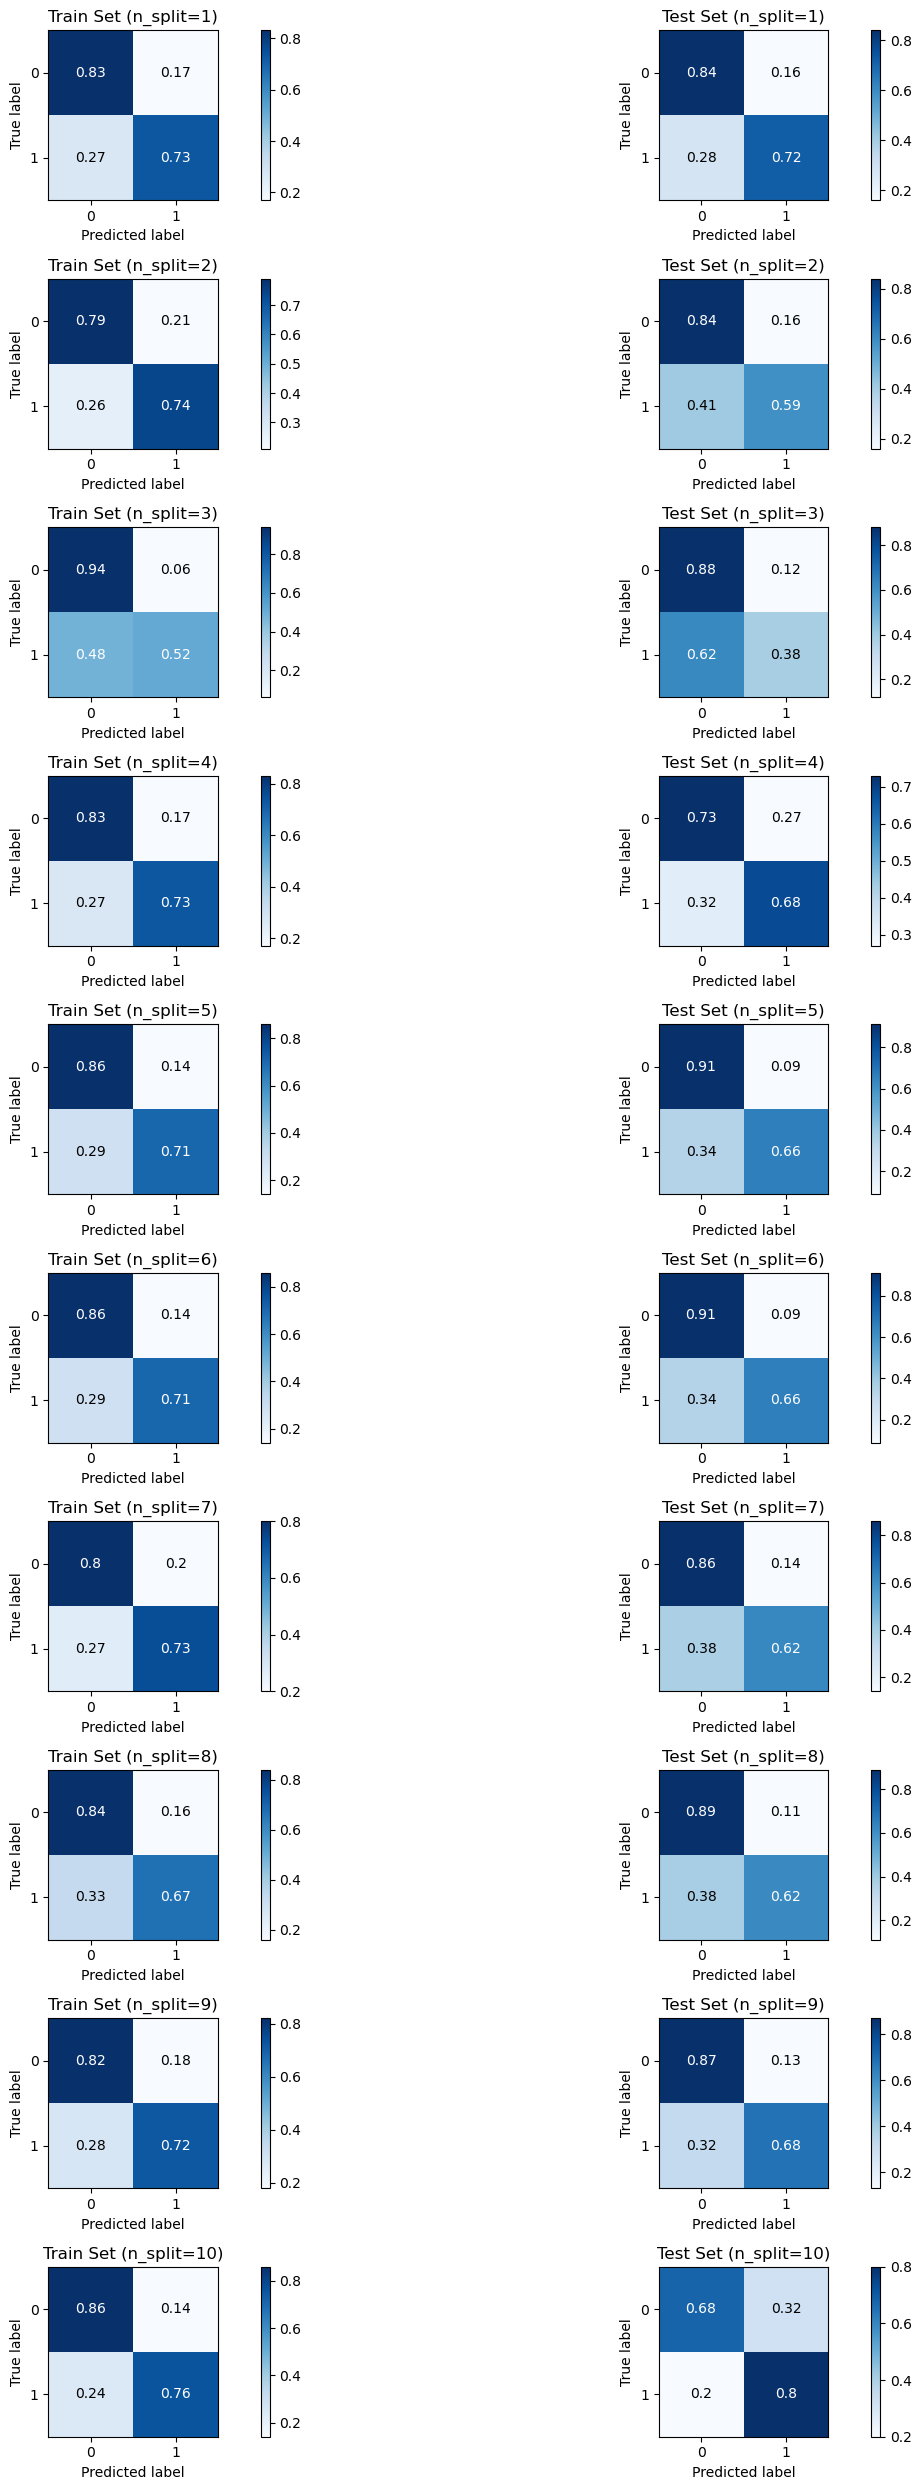

In [65]:
MyMultiTrainTester.plot_confusion(normalize=True, figsize=(15,25))

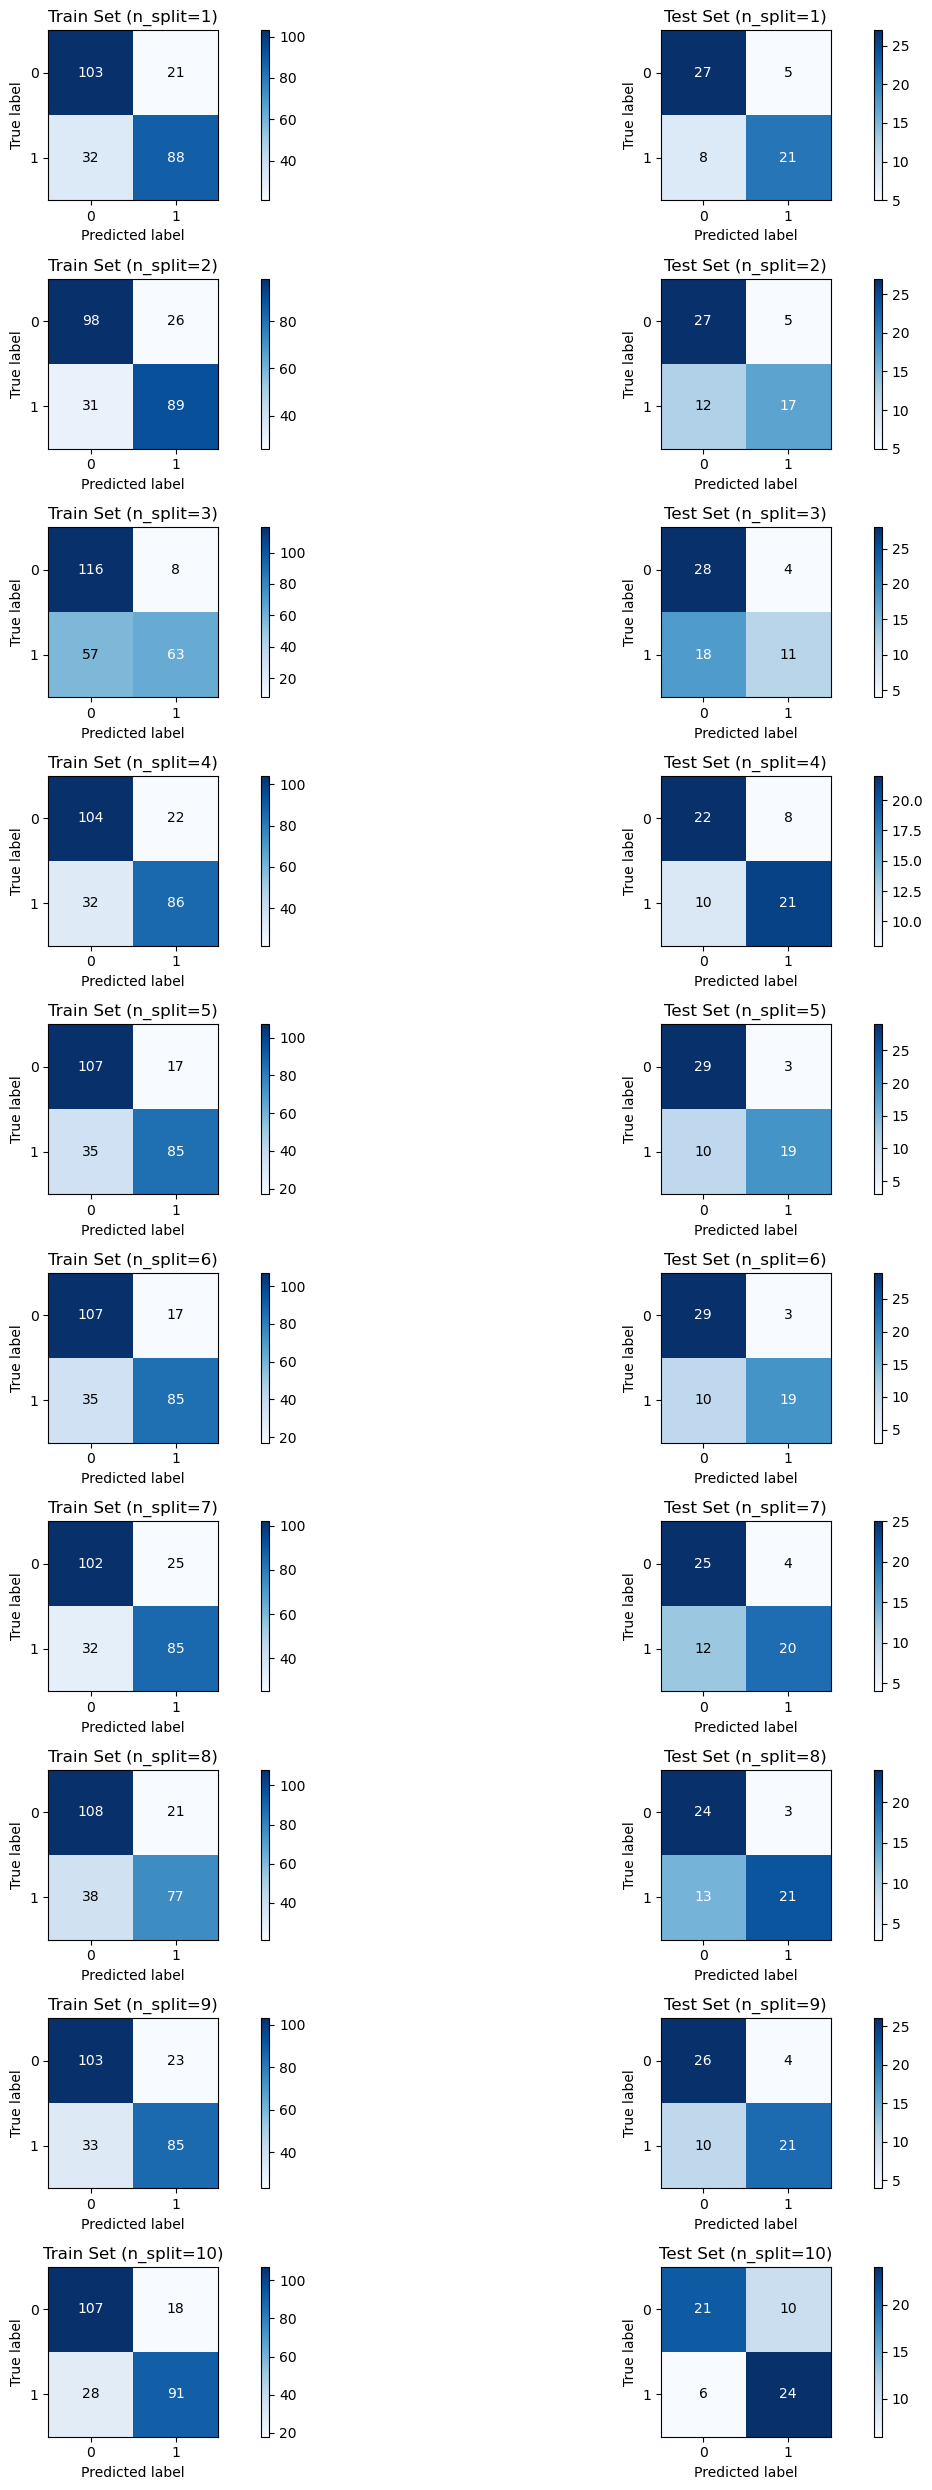

In [66]:
MyMultiTrainTester.plot_confusion(normalize=False, figsize=(15,25))

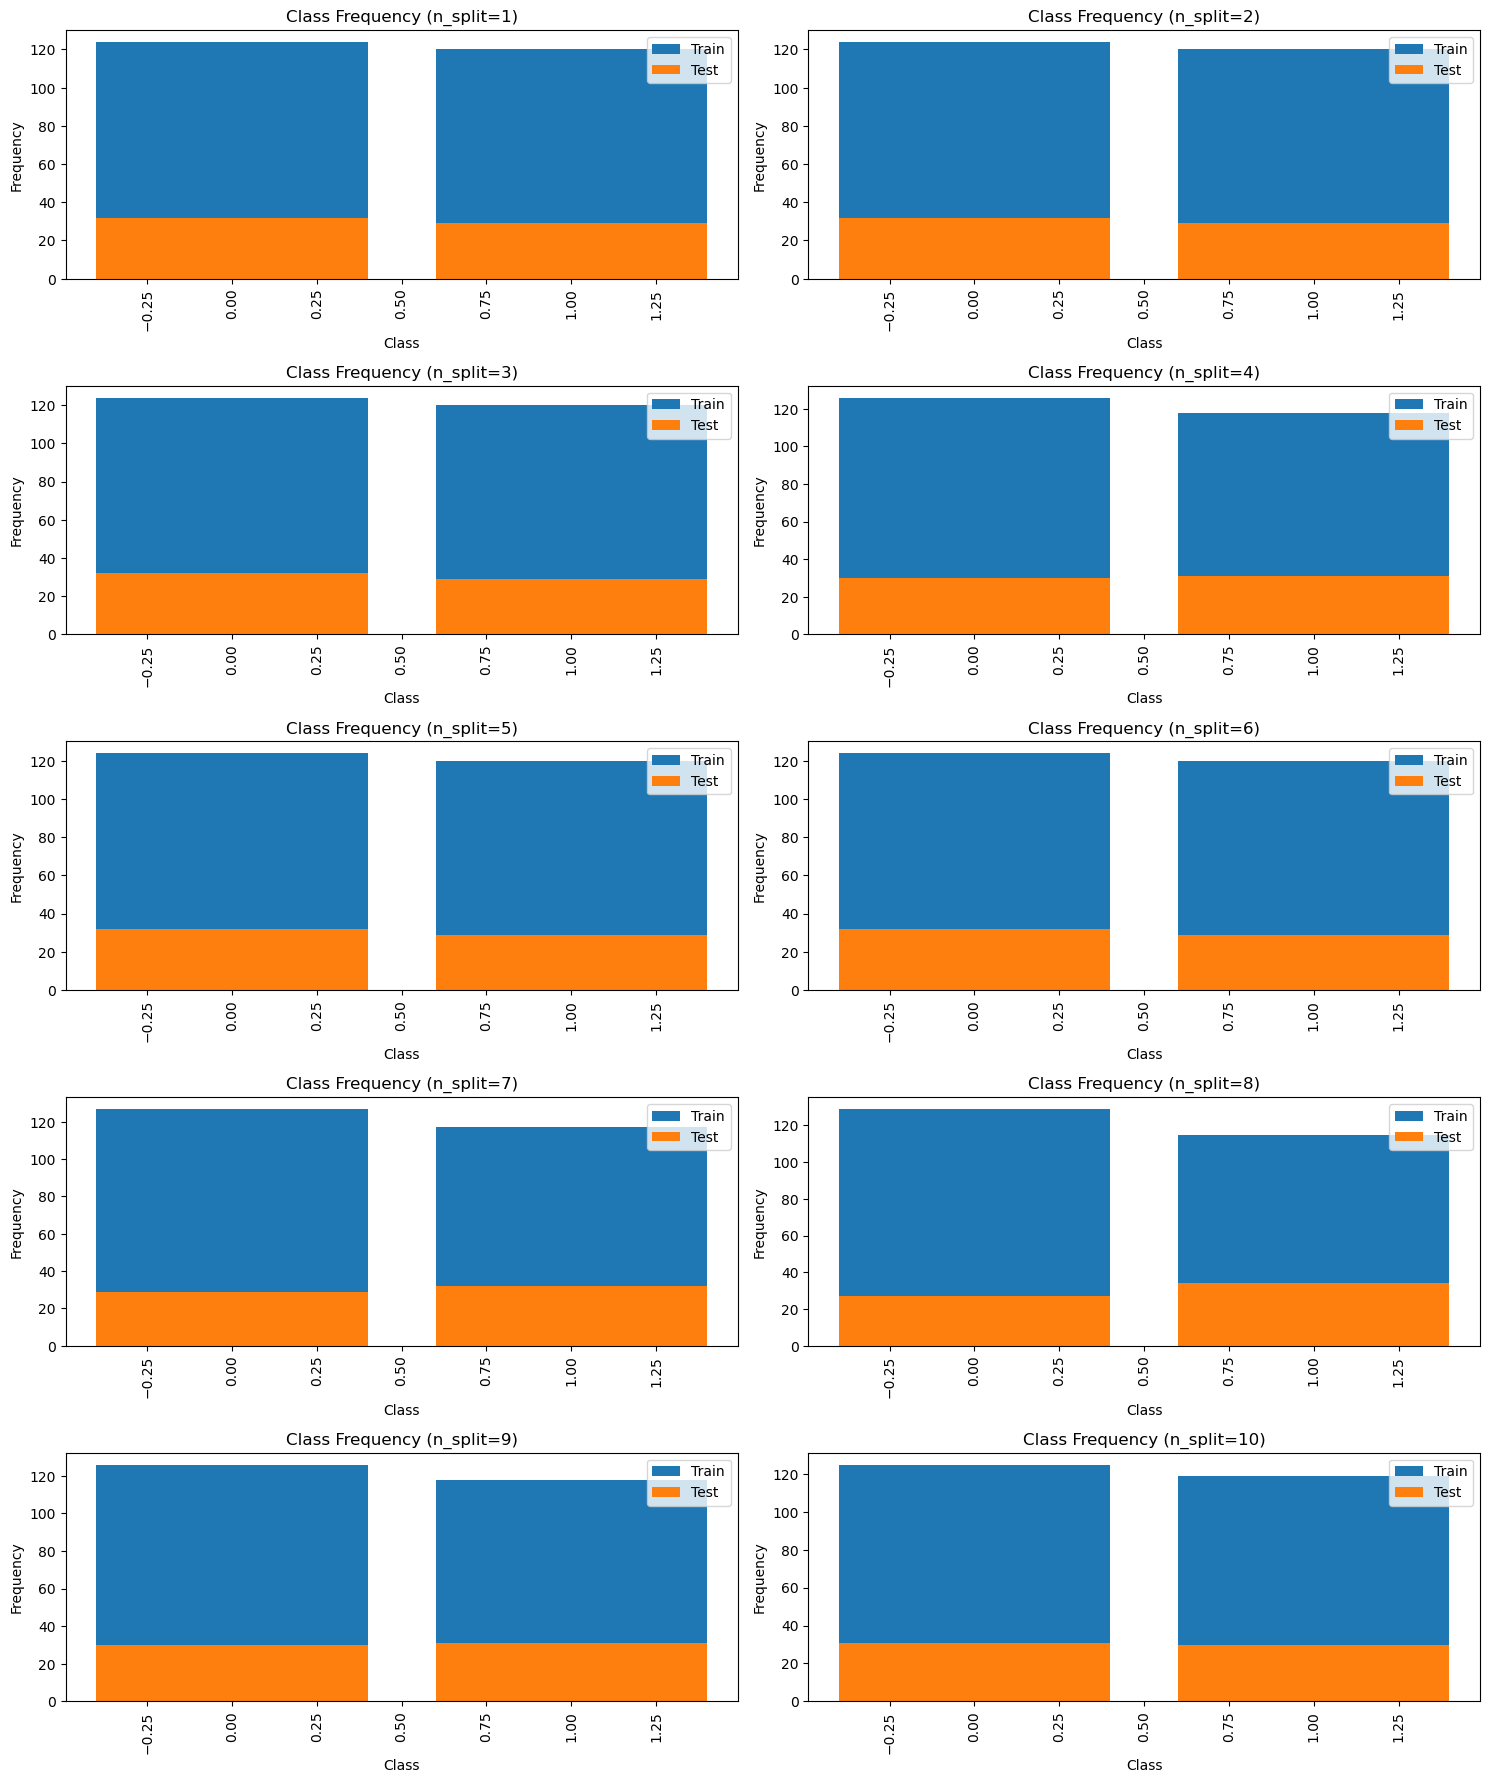

In [67]:
MyMultiTrainTester.plot_class_freq(normalize=True, figsize=(15,35))

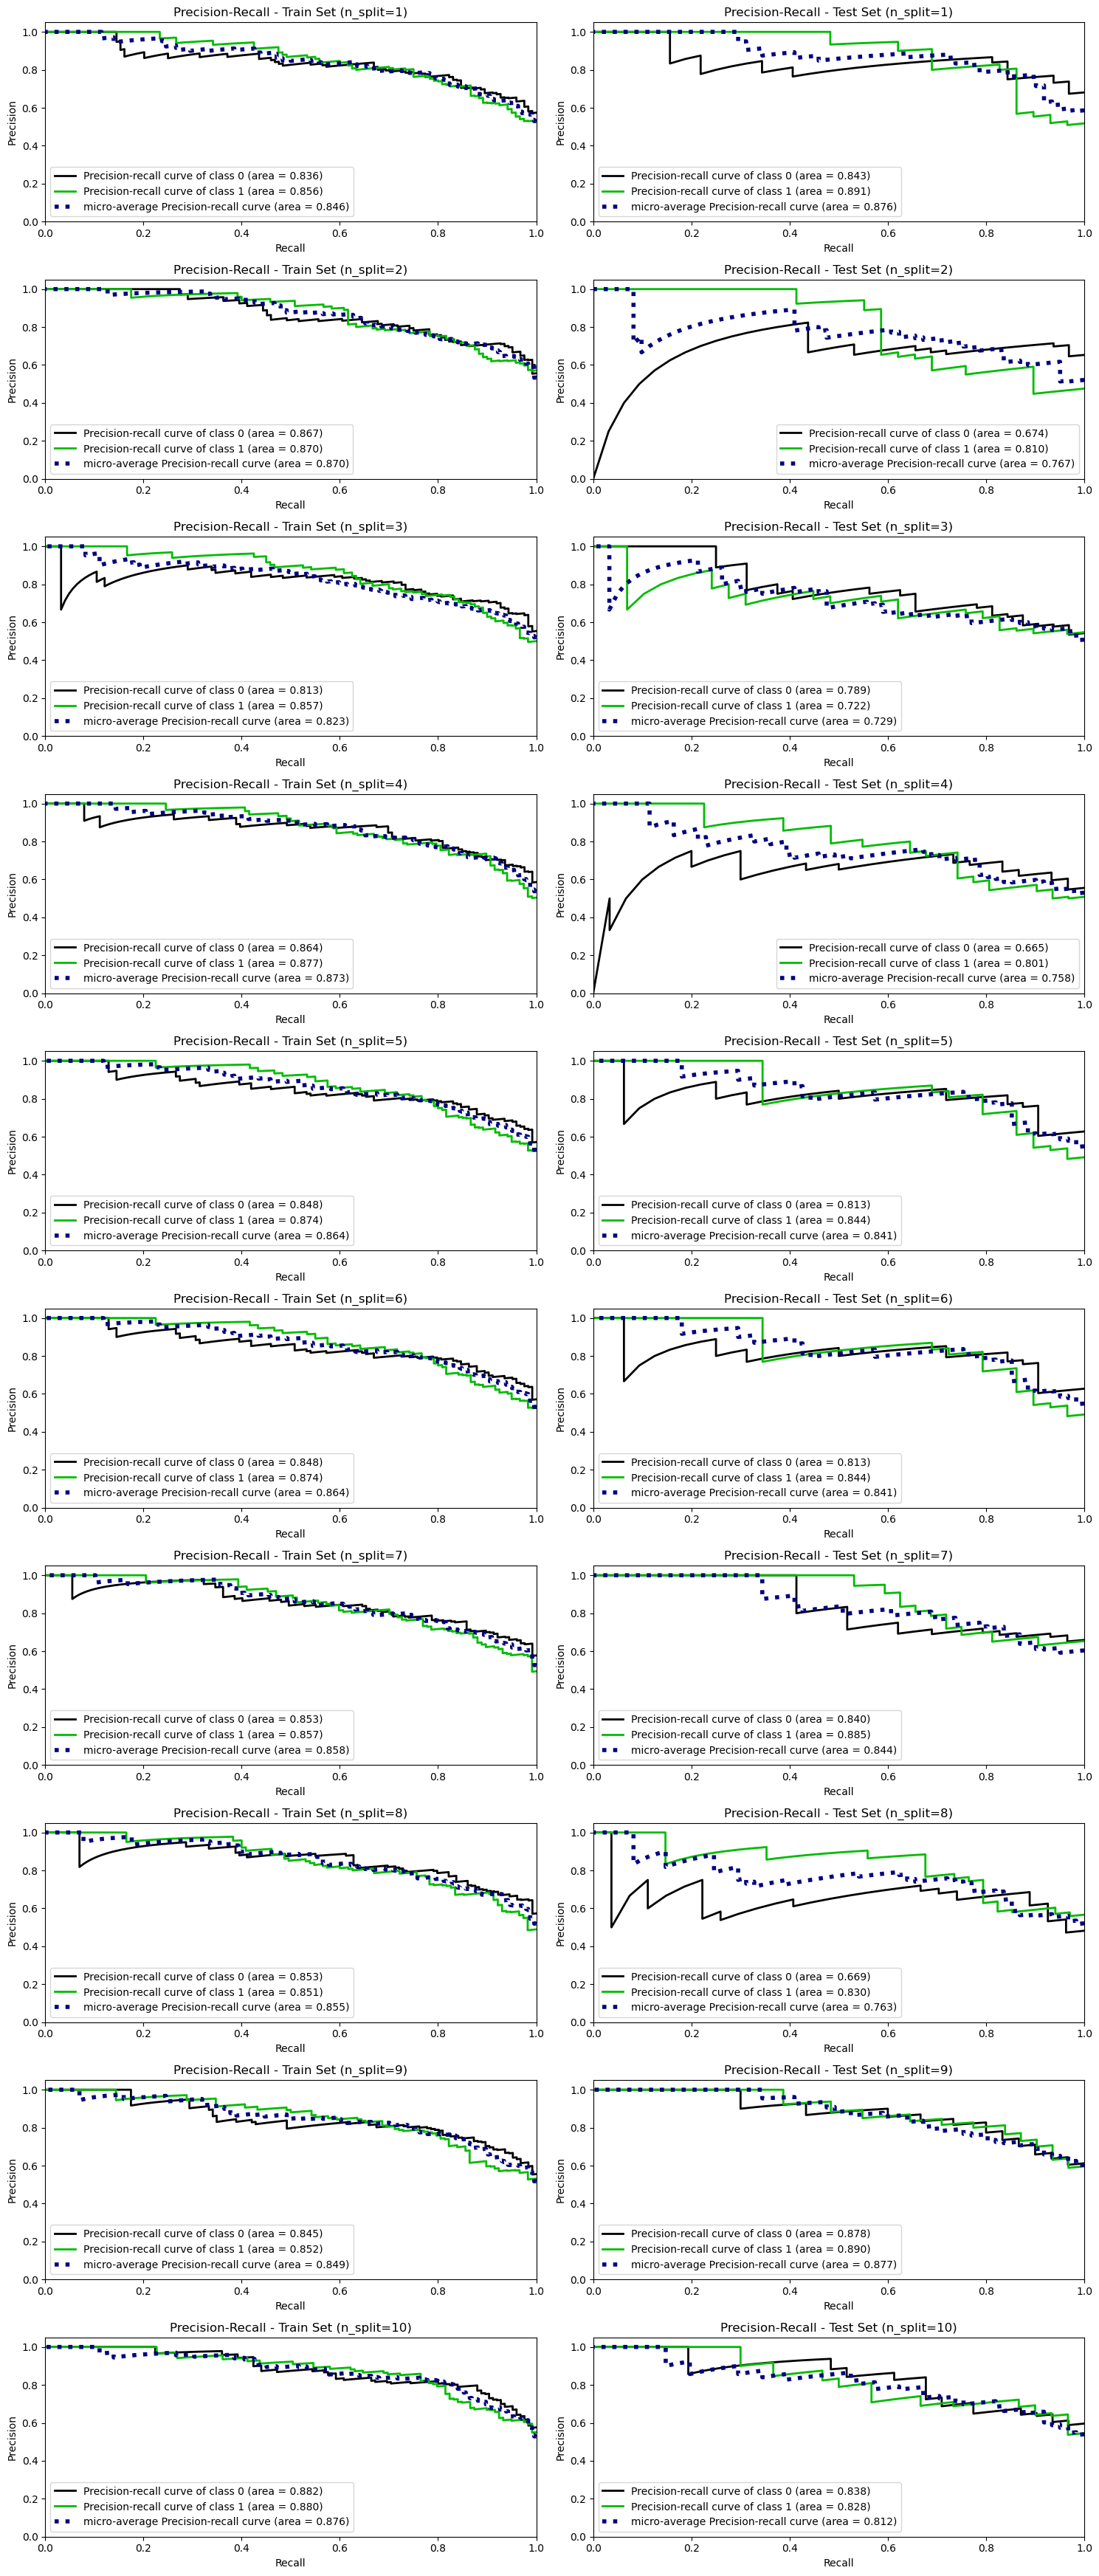

In [68]:
MyMultiTrainTester.plot_precrecall(figsize=(15,35))